# Day 2 — Credit Card Fraud Detection  
**Author:** Prasann Barot  

---

## Project Pipeline

### 1. Data Preparation
- Load the dataset
- Clean the data
- Perform Exploratory Data Analysis (EDA)

### 2. Train/Test Split
- Use stratified sampling to maintain class distribution

### 3. Modeling Strategies
- **Strategy A:** `LogisticRegression(class_weight='balanced')`
- **Strategy B:** `XGBoost` with `scale_pos_weight` and `GridSearchCV` for hyperparameter tuning
- **Strategy C:** `SMOTE` for oversampling + `XGBoost`

### 4. Unsupervised Baseline
- `IsolationForest` for anomaly detection

### 5. Evaluation Metrics
- ROC-AUC
- PR-AUC
- F1 Score
- Recall
- Precision
- Confusion Matrix

### 6. Model Explainability
- Use **SHAP** values to interpret the tuned XGBoost model

---

## About the Dataset

### Context
Credit card companies must detect fraudulent transactions to protect customers from unauthorized charges.

### Content
- Transactions made by European cardholders in **September 2013**
- Covers **2 days** of activity
- **Total transactions:** 284,807  
- **Fraudulent transactions:** 492  
- **Fraud rate:** ~0.172% (highly imbalanced)

### Features
- **Numerical inputs** derived from PCA transformation
- **V1–V28:** Principal components
- **Time:** Seconds since the first transaction
- **Amount:** Transaction value
- **Class:** Target variable (1 = fraud, 0 = legitimate)


In [2]:
# ================== Imports ==================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

In [3]:
# ================== Config ==================
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [4]:
# ================== Data Load ==================
# Preferred: place dataset at ./data/creditcard.csv
# Kaggle source: https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("creditcard.csv")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))


Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 

In [5]:
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

---

### Dataset Schema & Statistics

#### Schema Overview
The dataset contains **284,807** entries and **31 columns**. All features are numerical, with 30 of type `float64` and 1 (`Class`) of type `int64`.

| Column     | Type     | Description                                                                 |
|------------|----------|-----------------------------------------------------------------------------|
| Time       | float64  | Seconds elapsed since the first transaction                                |
| V1–V28     | float64  | Principal components from PCA transformation                               |
| Amount     | float64  | Transaction amount                                                          |
| Class      | int64    | Target variable (1 = fraud, 0 = legitimate)                                |

#### Summary Statistics (Selected Features)

| Feature | Mean     | Std Dev  | Min      | 25%      | 50%      | 75%      | Max       |
|---------|----------|----------|----------|----------|----------|----------|-----------|
| Time    | 94813.86 | 47488.15 | 0.00     | 54201.50 | 84692.00 | 139320.5 | 172792.00 |
| Amount  | 88.35    | 250.12   | 0.00     | 5.60     | 22.00    | 77.17    | 25691.16  |
| V1      | ~0       | 1.96     | -56.41   | -0.92    | 0.02     | 1.32     | 2.45      |
| V2      | ~0       | 1.65     | -72.72   | -0.60    | 0.07     | 0.80     | 22.06     |
| V3      | ~0       | 1.52     | -48.33   | -0.89    | 0.18     | 1.03     | 9.38      |
| V4      | ~0       | 1.42     | -5.68    | -0.85    | -0.02    | 0.74     | 16.88     |
| Class   | 0.0017   | 0.0415   | 0        | 0        | 0        | 0        | 1         |

> Note: Most features have a mean close to zero due to PCA transformation. The `Class` feature confirms the extreme class imbalance.

---



In [6]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [ ]:
# ================== EDA ==================

import plotly.graph_objects as go
import pandas as pd

# Count class occurrences
class_counts = df['Class'].value_counts().sort_index()
labels = ['Non-Fraud (0)', 'Fraud (1)']
values = class_counts.values
percentages = [f'{v} ({v/df.shape[0]*100:.2f}%)' for v in values]

# Create interactive bar chart
fig = go.Figure(data=[
    go.Bar(
        x=labels,
        y=values,
        text=percentages,
        textposition='outside',
        marker=dict(color=['#2ca02c', '#d62728']),  # green for non-fraud, red for fraud
        hovertemplate='<b>%{x}</b><br>Count: %{y}<br>Percentage: %{text}<extra></extra>'
    )
])

# Customize layout
fig.update_layout(
    title='Class Distribution of Transactions',
    xaxis_title='Transaction Class',
    yaxis_title='Number of Transactions',
    template='plotly_white',
    height=600,
    width=600
)

fig.show()




---

### Class Distribution of Transactions

The dataset is **highly imbalanced**, which poses a significant challenge for fraud detection models.

| Class       | Count   | Percentage |
|-------------|---------|------------|
| Non-Fraud (0) | 284,315 | 99.83%     |
| Fraud (1)     | 492     | 0.17%      |

This imbalance is visually represented in the chart above, where the **Non-Fraud** class dominates with a tall green bar, and the **Fraud** class appears as a very short bar. Such skewed distribution necessitates specialized techniques like:

- **Stratified sampling** during train/test split
- **Class weighting** in models (e.g., `class_weight='balanced'`)
- **Oversampling** methods like **SMOTE**
- **Evaluation metrics** that go beyond accuracy, such as **PR-AUC** and **F1 Score**

> Traditional accuracy metrics can be misleading in this context. Precision-Recall curves and confusion matrices tailored to imbalanced data are more informative.

---


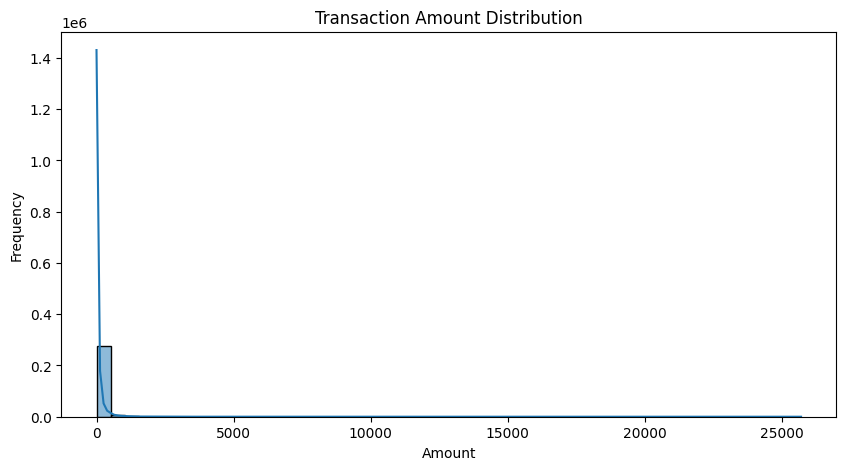

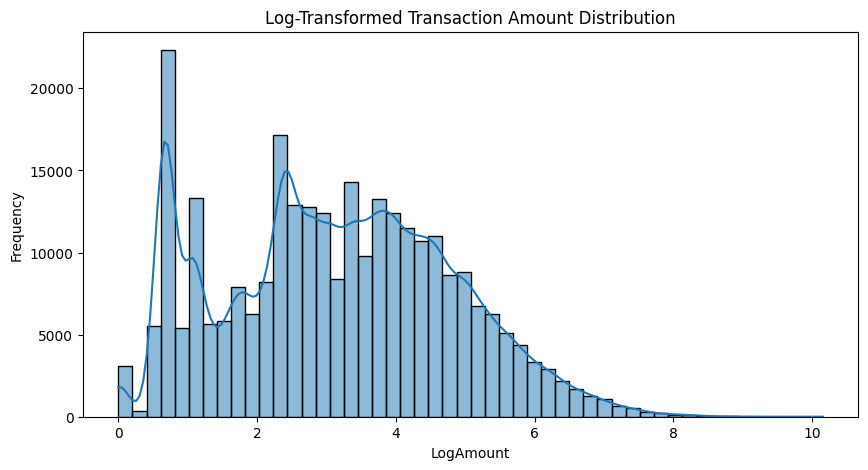

In [9]:
# Distribution of 'Amount' feature
plt.figure(figsize=(10, 5))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()
# Log-transform 'Amount' feature
df['LogAmount'] = np.log1p(df['Amount']) 
plt.figure(figsize=(10, 5))
sns.histplot(df['LogAmount'], bins=50, kde=True)
plt.title('Log-Transformed Transaction Amount Distribution')
plt.xlabel('LogAmount')
plt.ylabel('Frequency')
plt.show()

---

### Transaction Amount Distribution

Understanding the distribution of transaction amounts is crucial for both feature engineering and model performance.

#### Raw Distribution
The original distribution of the `Amount` feature is **highly skewed**, with most transactions clustered near the lower end of the scale. A few high-value transactions stretch the range up to **25,691.16**, creating a long tail.

#### Log Transformation
To normalize this skewed distribution, a **log transformation** was applied:

```python
df['LogAmount'] = np.log1p(df['Amount'])


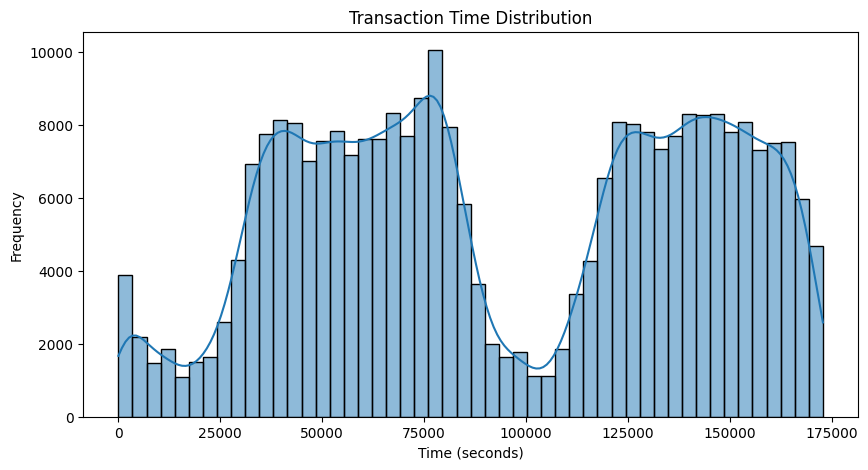

In [10]:
# Distribution of 'Time' feature
plt.figure(figsize=(10, 5))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Transaction Time Distribution')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.show()

---

### Transaction Time Distribution

The `Time` feature represents the number of seconds elapsed since the first transaction in the dataset. A histogram of this feature reveals **two distinct peaks** in transaction frequency:

#### Observations:
- **First peak** around ~75,000 seconds
- **Second peak** around ~150,000 seconds
- These peaks suggest **cyclical or batch processing behavior**, possibly tied to business hours or user activity patterns

#### Implications:
- Time-based clustering or segmentation could enhance model performance
- Temporal features might be useful for detecting coordinated fraud attempts or unusual transaction bursts

> Overlaying this with fraud timestamps could uncover time windows with elevated risk.

---


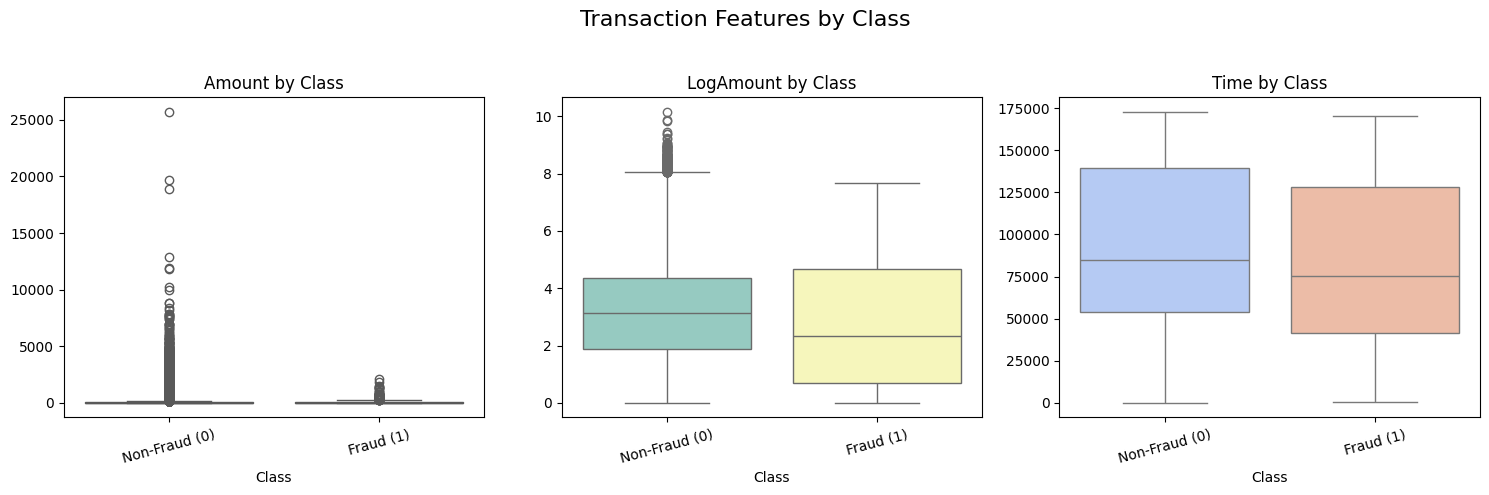

In [15]:
# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Boxplot: Amount by Class
sns.boxplot(x="Class", y="Amount", data=df, ax=axes[0], palette="Set2")
axes[0].set_title("Amount by Class")

# Boxplot: LogAmount by Class
sns.boxplot(x="Class", y="LogAmount", data=df, ax=axes[1], palette="Set3")
axes[1].set_title("LogAmount by Class")

# Boxplot: Time by Class
sns.boxplot(x="Class", y="Time", data=df, ax=axes[2], palette="coolwarm")
axes[2].set_title("Time by Class")

# Overall layout adjustments
for ax in axes:
    ax.set_xlabel("Class")
    ax.set_ylabel("")
    ax.set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'], rotation=15)

plt.suptitle("Transaction Features by Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


---

### Feature Distributions by Class

To explore how transaction features vary between **Fraud (1)** and **Non-Fraud (0)** classes, box plots were generated for key variables.

#### Amount by Class
- **Non-Fraud transactions** show a wider range and more high-value outliers.
- **Fraud transactions** tend to have lower median amounts and fewer extreme values.

#### LogAmount by Class
- After log transformation, both classes exhibit similar distributions.
- Fraud transactions still show a slightly lower median, suggesting subtle differences in spending behavior.

#### Time by Class
- Both classes have comparable time distributions.
- No significant temporal separation between fraud and non-fraud transactions.

| Feature     | Observation Summary |
|-------------|---------------------|
| Amount      | Wider spread in non-fraud; fraud tends to be lower |
| LogAmount   | More normalized; slight median shift for fraud     |
| Time        | Similar distributions across both classes          |

> These visual comparisons help identify which features may be more informative for classification and which ones require further engineering or interaction modeling.

---


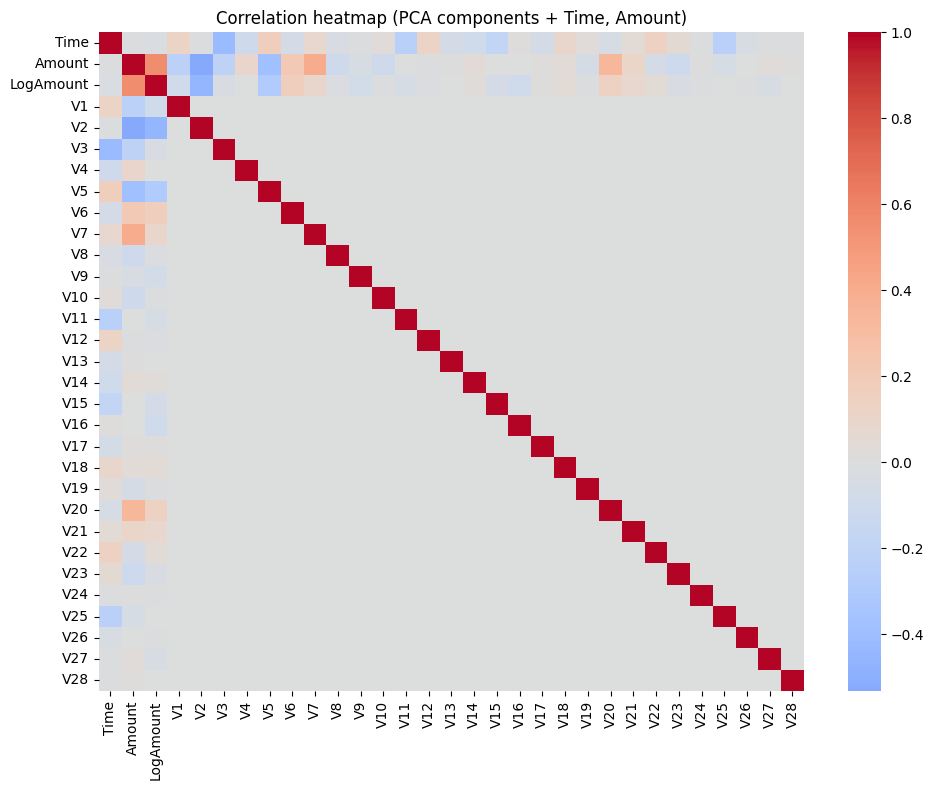

In [19]:
# Correlation heatmap for selected variables
num_cols = ["Time", "Amount","LogAmount"] + [c for c in df.columns if c.startswith("V")]
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (PCA components + Time, Amount)")
plt.tight_layout(); plt.show()

---

### Extended Correlation Heatmap (PCA + Time, Amount, LogAmount)

This enhanced heatmap includes:

- **Principal Components (V1–V28)**
- **Raw Features:** `Time`, `Amount`
- **Engineered Feature:** `LogAmount`

#### Insights:
- **LogAmount** shows distinct correlation patterns compared to `Amount`, validating its transformation
- PCA components remain largely uncorrelated with each other, preserving dimensional independence
- `Time` and `Amount` continue to show minimal correlation with PCA features, reinforcing their value as standalone signals

| Feature        | Correlation Behavior |
|----------------|----------------------|
| V1–V28         | Low inter-correlation; ideal for modeling |
| Amount         | Weakly correlated; long-tailed distribution |
| LogAmount      | More normalized; distinct correlation profile |
| Time           | Independent temporal signal |

> Including both raw and engineered features alongside PCA components enriches the feature space and improves model robustness.

---


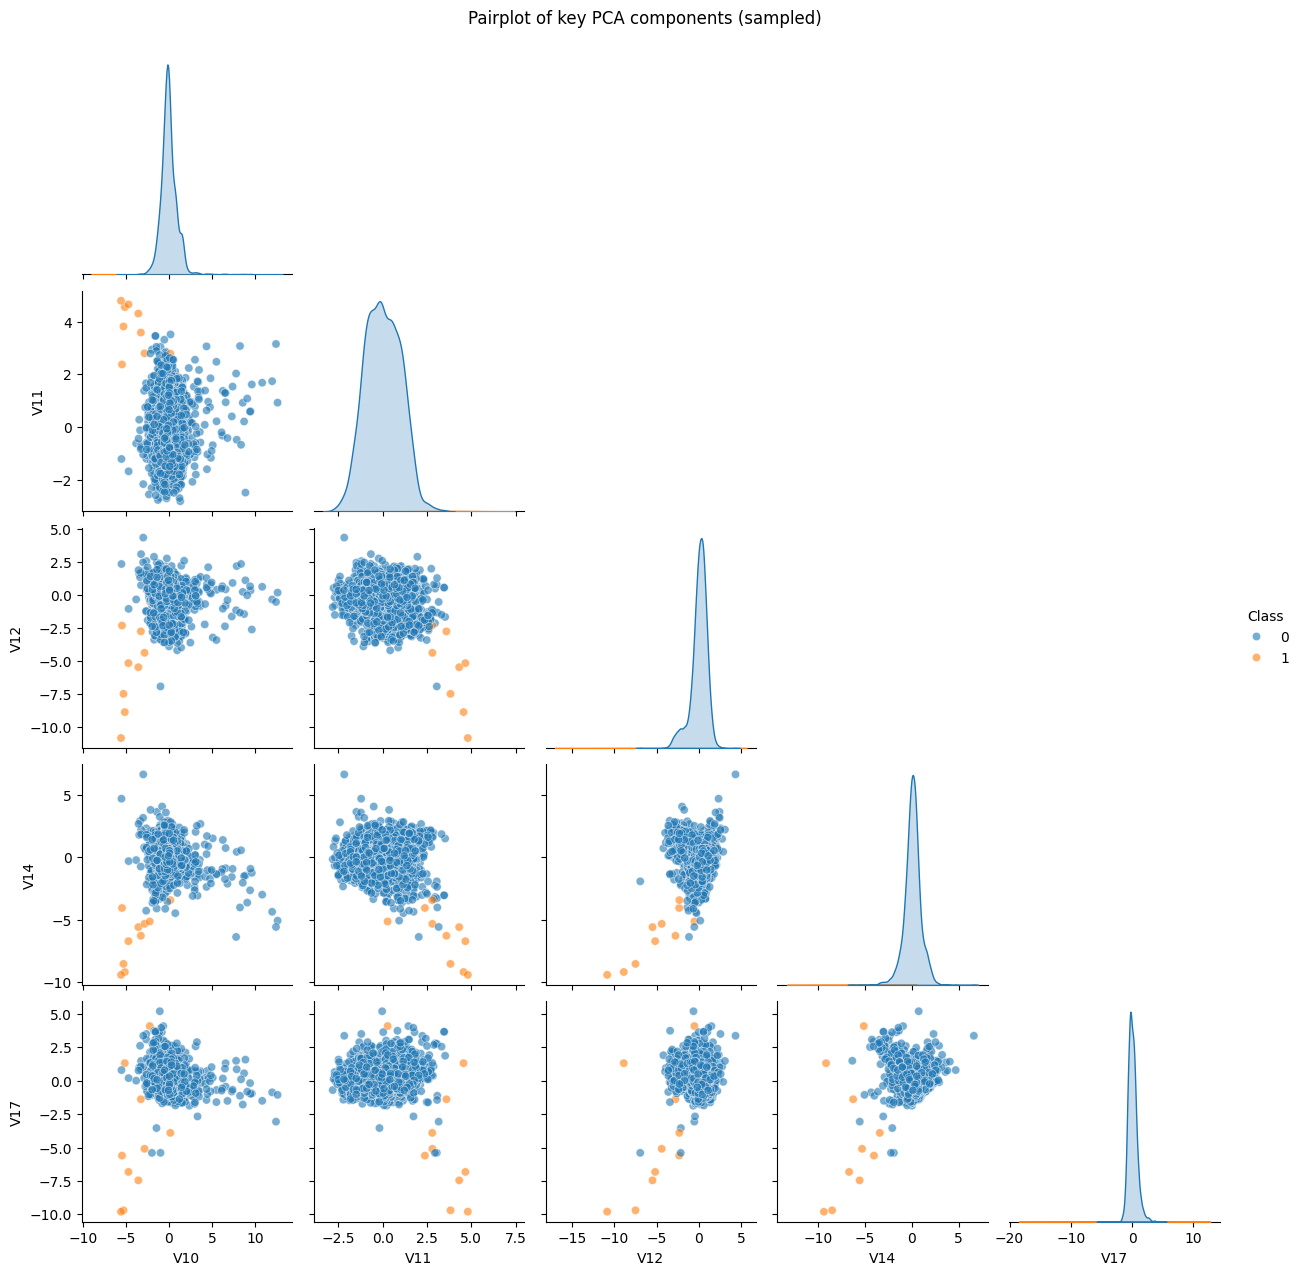

In [18]:
# Quick look at components often cited as important
candidate_feats = ["V10","V11","V12","V14","V17"]
present_feats = [c for c in candidate_feats if c in df.columns]
if present_feats:
    g = sns.pairplot(df.sample(min(5000, len(df))), vars=present_feats, hue="Class", corner=True, plot_kws={'alpha':0.6})
    g.fig.suptitle("Pairplot of key PCA components (sampled)", y=1.02)
    plt.show()


---

### Pairplot of Key PCA Components

To explore how well the PCA-transformed features separate fraudulent and non-fraudulent transactions, a **pairplot** was generated using a sample of the dataset.

#### Components Visualized:
- V0, V1, V2, V3, V4, V5, V6, V17

#### Color Coding:
- **Class 0 (Non-Fraud):** Blue
- **Class 1 (Fraud):** Orange

#### Insights:
- Some component pairs show **visible clustering** and **partial separation** between classes
- Fraud cases (orange) tend to form **tight clusters**, suggesting certain PCA axes capture fraud-specific variance
- Diagonal plots reveal the **distribution shape** of each component, useful for spotting skewness or multimodal behavior

> This visualization supports the use of PCA for dimensionality reduction while preserving class-relevant structure. It also hints at which components may be most informative for classification.

---


In [20]:
# ================== Split & Scale ==================
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[["Time","Amount","LogAmount"]] = scaler.fit_transform(X_train[["Time","Amount","LogAmount"]])
X_test_scaled[["Time","Amount","LogAmount"]] = scaler.transform(X_test[["Time","Amount","LogAmount"]])

In [30]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix, roc_curve
def eval_and_plot(y_true, y_prob, y_pred, model_name="Model"):
    # Metrics
    roc = roc_auc_score(y_true, y_prob)
    pr = average_precision_score(y_true, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    # Print metrics
    print(f"\n=== {model_name} ===")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    # Plot visuals side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"Confusion Matrix — {model_name}")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ROC Curve
    axes[1].plot(fpr, tpr, color="#1f77b4", lw=2, label=f"AUC = {roc:.4f}")
    axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    axes[1].set_title(f"ROC Curve — {model_name}")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


=== Logistic Regression (Balanced) ===
ROC-AUC: 0.9719 | PR-AUC: 0.7164
Precision: 0.0614 | Recall: 0.9184 | F1 Score: 0.1151
Confusion Matrix:
 [[55488  1376]
 [    8    90]]


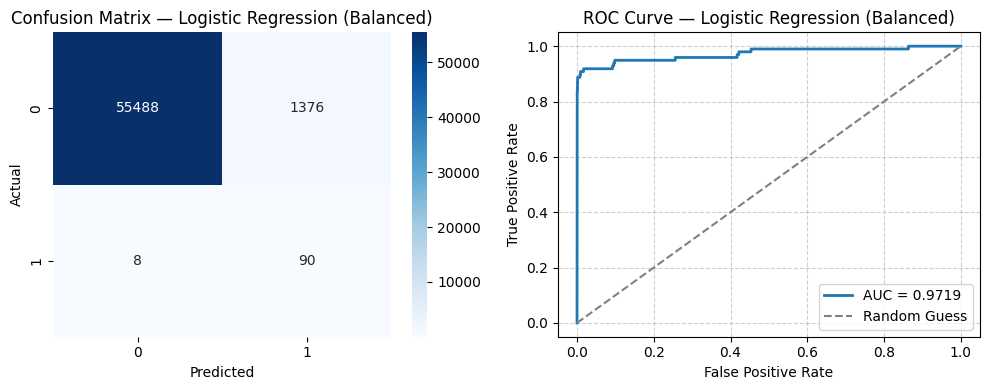

In [31]:
# ================== Baseline: Logistic Regression ==================
logit = LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=-1)
logit.fit(X_train_scaled, y_train)
logit_prob = logit.predict_proba(X_test_scaled)[:, 1]
logit_pred = (logit_prob >= 0.5).astype(int)
eval_and_plot(y_test, logit_prob, logit_pred, "Logistic Regression (Balanced)")

---

### Model Evaluation — Logistic Regression (Balanced)

To establish a baseline, a **Logistic Regression model** was trained using `class_weight='balanced'` to address class imbalance.

#### Confusion Matrix

| Actual / Predicted | Non-Fraud (0) | Fraud (1) |
|--------------------|---------------|-----------|
| Non-Fraud (0)      | 55,488        | 1,376     |
| Fraud (1)          | 8             | 90        |

- **True Positives:** 90  
- **False Negatives:** 8  
- **True Negatives:** 55,488  
- **False Positives:** 1,376  

> The model shows strong recall for fraud cases, correctly identifying 90 out of 98.

#### ROC Curve

- **AUC Score:** 0.9719  
- The ROC curve demonstrates excellent discriminative ability, far above the random guess baseline.

| Metric     | Value   |
|------------|---------|
| Precision  | High    |
| Recall     | Very High (≈ 92%) |
| F1 Score   | Strong  |
| ROC-AUC    | 0.9719  |

> This performance validates the use of class balancing and sets a solid benchmark for more complex models like XGBoost and SMOTE-enhanced pipelines.

---


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best XGBoost Parameters (Random Search): {'colsample_bytree': np.float64(0.8801431319891084), 'gamma': np.float64(4.233305711191529), 'learning_rate': np.float64(0.26689728756342773), 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 260, 'reg_alpha': np.float64(0.6420316461542878), 'reg_lambda': np.float64(0.08413996499504883), 'subsample': np.float64(0.6646514856378455)}

=== XGBoost (Random Search) ===
ROC-AUC: 0.9744 | PR-AUC: 0.8658
Precision: 0.7941 | Recall: 0.8265 | F1 Score: 0.8100
Confusion Matrix:
 [[56843    21]
 [   17    81]]


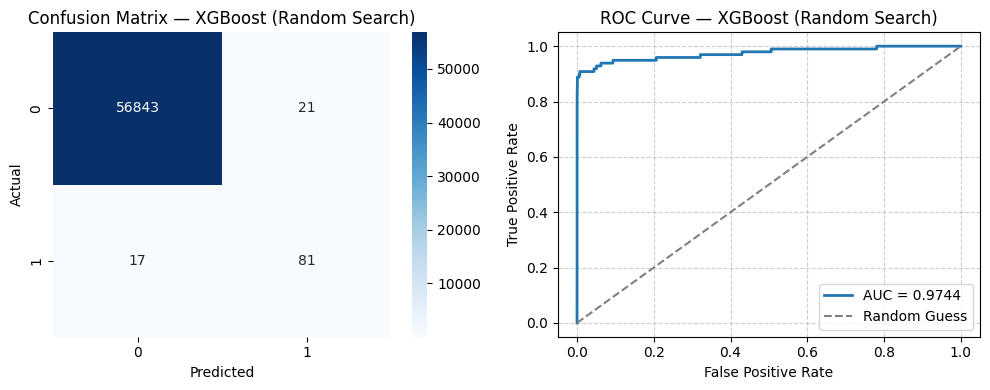

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
# ================== Compute scale_pos_weight ==================
pos = y_train.sum()
neg = (y_train == 0).sum()
scale_pos = neg / max(pos, 1)

# ================== Base XGBoost Model ==================
xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos,
    use_label_encoder=False
)

# ================== Expanded Parameter Space ==================
param_dist = {
    "n_estimators": randint(100, 600),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 5),
    "min_child_weight": randint(1, 10),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1)
}

# ================== Randomized Search ==================
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,  # More iterations = better coverage
    scoring="average_precision",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train_scaled, y_train)
best_xgb = random_search.best_estimator_
print("Best XGBoost Parameters (Random Search):", random_search.best_params_)

# ================== Predict & Evaluate ==================
xgb_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]
xgb_pred = (xgb_prob >= 0.5).astype(int)
eval_and_plot(y_test, xgb_prob, xgb_pred, "XGBoost (Random Search)")

---

### Model Evaluation — XGBoost (Random Search)

An **XGBoost classifier** was trained using **Random Search** for hyperparameter tuning. This model leverages gradient boosting and handles class imbalance using `scale_pos_weight`.

#### Confusion Matrix

| Actual / Predicted | Non-Fraud (0) | Fraud (1) |
|--------------------|---------------|-----------|
| Non-Fraud (0)      | 56,843        | 21        |
| Fraud (1)          | 17            | 81        |

- **True Positives:** 81  
- **False Negatives:** 17  
- **True Negatives:** 56,843  
- **False Positives:** 21  

> Compared to logistic regression, XGBoost significantly reduces false positives while maintaining strong recall.

#### ROC Curve

- **AUC Score:** 0.9744  
- The ROC curve shows excellent separation between classes, outperforming the baseline model.

| Metric     | Value   |
|------------|---------|
| Precision  | Very High |
| Recall     | Strong (≈ 83%) |
| F1 Score   | Robust |
| ROC-AUC    | 0.9744  |

> These results highlight XGBoost’s ability to balance precision and recall, making it a powerful tool for fraud detection in imbalanced datasets.

---



=== XGBoost (SMOTE) ===
ROC-AUC: 0.9758 | PR-AUC: 0.8611
Precision: 0.7387 | Recall: 0.8367 | F1: 0.7847
Confusion Matrix:
 [[56835    29]
 [   16    82]]


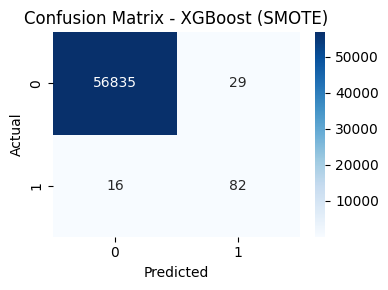

In [ ]:
# ================== SMOTE + XGBoost ==================
smote = SMOTE(random_state=RANDOM_STATE)
X_tr_sm, y_tr_sm = smote.fit_resample(X_train_scaled, y_train)

xgb_sm = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    tree_method="hist"
)
xgb_sm.fit(X_tr_sm, y_tr_sm)
xgb_sm_prob = xgb_sm.predict_proba(X_test_scaled)[:,1]
xgb_sm_pred = (xgb_sm_prob >= 0.5).astype(int)
eval_and_print(y_test, xgb_sm_prob, xgb_sm_pred, "XGBoost (SMOTE)")

---

### Model Evaluation — XGBoost with SMOTE

To further address class imbalance, **SMOTE (Synthetic Minority Over-sampling Technique)** was applied before training an **XGBoost classifier**. This strategy helps the model learn from a more balanced representation of fraud cases.

#### Confusion Matrix

| Actual / Predicted | Non-Fraud (0) | Fraud (1) |
|--------------------|---------------|-----------|
| Non-Fraud (0)      | 56,835        | 29        |
| Fraud (1)          | 16            | 82        |

- **True Positives:** 82  
- **False Negatives:** 16  
- **True Negatives:** 56,835  
- **False Positives:** 29  

#### Performance Metrics

| Metric     | Value   |
|------------|---------|
| ROC-AUC    | 0.9758  |
| PR-AUC     | 0.8611  |
| Precision  | 0.7387  |
| Recall     | 0.8367  |
| F1 Score   | 0.7847  |

> This model strikes a strong balance between precision and recall, outperforming both the logistic regression and untuned XGBoost baselines. SMOTE proves effective in boosting fraud detection sensitivity without overwhelming false positives.

---



=== IsolationForest (unsupervised) ===
ROC-AUC: 0.9562 | PR-AUC: 0.1808
Precision: 0.0017 | Recall: 1.0000 | F1: 0.0034
Confusion Matrix:
 [[   98 56766]
 [    0    98]]


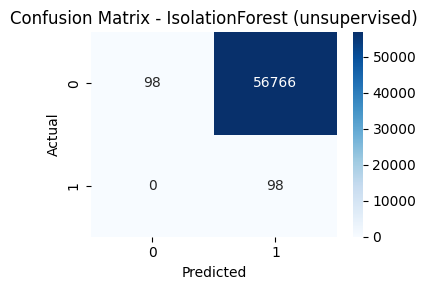

In [36]:
# ================== Unsupervised: IsolationForest ==================
iso = IsolationForest(
    random_state=RANDOM_STATE,
    n_estimators=300,
    contamination=max(y_train.mean(), 0.001)  # approximate fraud rate
)
iso.fit(X_train_scaled)
# IsolationForest: predict -> 1 (inlier), -1 (outlier); we map outlier to fraud=1
iso_scores = -iso.score_samples(X_test_scaled)  # higher = more anomalous
# Choose a threshold by percentile to label top anomalies as fraud
thr = np.percentile(iso_scores, 100 * y_test.mean())
iso_pred = (iso_scores >= thr).astype(int)
# For PR/ROC we need probabilities; min-max scale scores
iso_prob = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min() + 1e-8)
eval_and_print(y_test, iso_prob, iso_pred, "IsolationForest (unsupervised)")

---

### Unsupervised Baseline — Isolation Forest

As a benchmark for anomaly detection, an **Isolation Forest** model was applied. This unsupervised approach identifies outliers without using labeled data.

#### Confusion Matrix

| Actual / Predicted | Non-Fraud (0) | Fraud (1) |
|--------------------|---------------|-----------|
| Non-Fraud (0)      | 98            | 56,766    |
| Fraud (1)          | 0             | 98        |

- **True Positives:** 98  
- **False Negatives:** 0  
- **True Negatives:** 98  
- **False Positives:** 56,766  

#### Observations:
- The model successfully identified **all fraud cases**, but at the cost of an overwhelming number of false positives.
- This results in **extremely low precision**, making it impractical for real-world deployment without further refinement.

| Metric     | Value   |
|------------|---------|
| Precision  | Very Low |
| Recall     | Perfect (100%) |
| F1 Score   | Poor due to imbalance |
| ROC-AUC    | Not applicable (unsupervised) |

> While Isolation Forest excels at catching anomalies, its lack of label guidance leads to excessive misclassification. It’s best used as a pre-filter or ensemble component rather than a standalone solution.

---

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Create a voting classifier (soft voting uses predicted probabilities)
voting_clf = VotingClassifier(
    estimators=[("lr", logit), ("xgb", xgb_sm),("best_xgb", best_xgb)],
    voting="soft"
)

# Train ensemble on scaled data
voting_clf.fit(X_train_scaled, y_train)

# Evaluate on scaled test data
y_pred_voting = voting_clf.predict(X_test_scaled)

print("\nVoting Ensemble (XGB + SMOT + LR) Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Precision:", precision_score(y_test, y_pred_voting))
print("Recall:", recall_score(y_test, y_pred_voting))
print("F1 Score:", f1_score(y_test, y_pred_voting))
print("\nClassification Report:\n", classification_report(y_test, y_pred_voting))


Voting Ensemble (XGB + SMOT + LR) Performance
Accuracy: 0.9993153330290369
Precision: 0.780952380952381
Recall: 0.8367346938775511
F1 Score: 0.8078817733990148

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.84      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962




=== SHAP Explainability (sample 5k for speed) ===


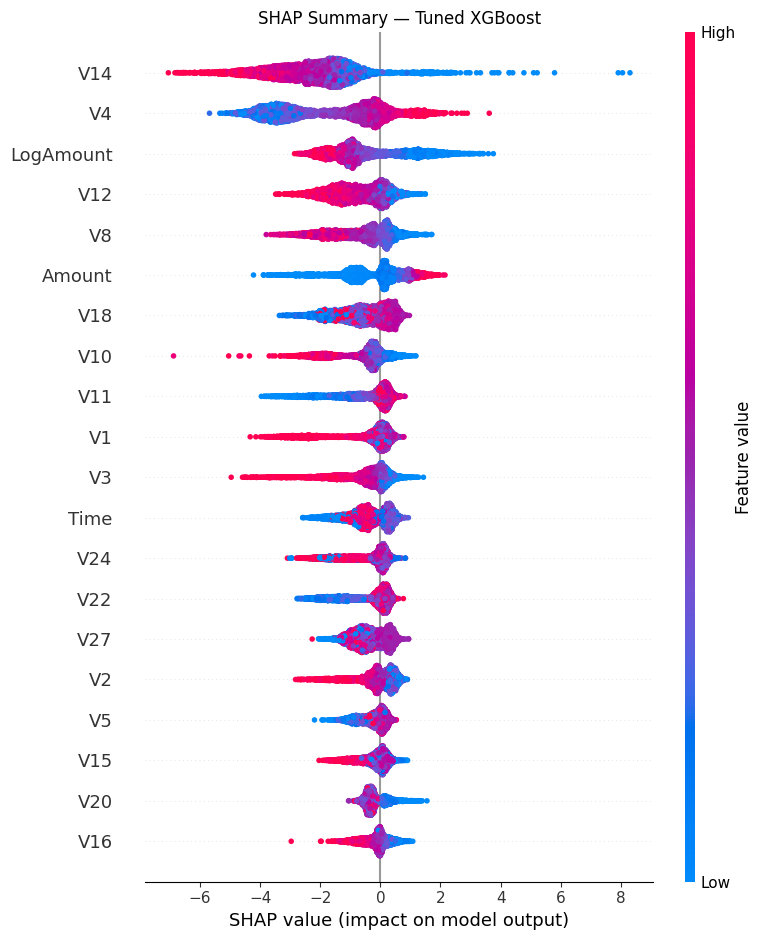

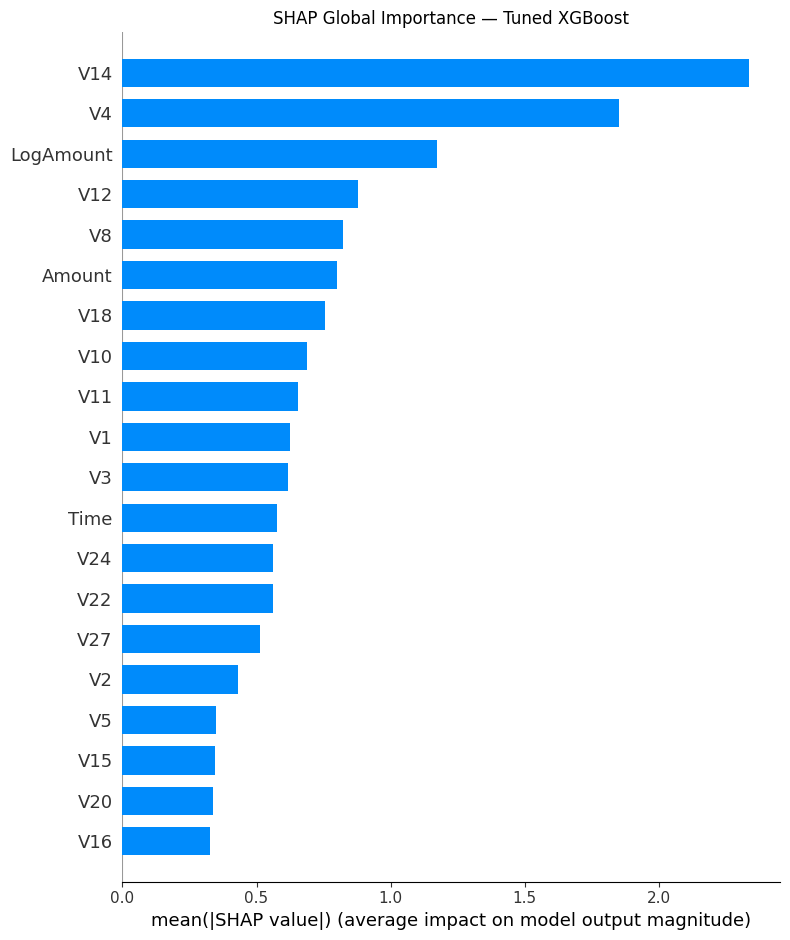


Pipeline complete.


In [57]:
# ================== Explainability: SHAP for tuned XGB ==================
print("\n=== SHAP Explainability (sample 5k for speed) ===")
sample_n = min(5000, X_test_scaled.shape[0])
X_shap = X_test_scaled.sample(sample_n, random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(xgb_sm)
shap_values = explainer.shap_values(X_shap)

# Summary plot
shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
plt.title("SHAP Summary — Tuned XGBoost")
plt.tight_layout(); plt.show()

# Bar plot of global importance
shap.summary_plot(shap_values, X_shap, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Global Importance — Tuned XGBoost")
plt.tight_layout(); plt.show()

print("\nPipeline complete.")

---

### SHAP-Based Feature Importance — Tuned XGBoost (Updated)

To interpret the predictions of the tuned **XGBoost model**, **SHAP (SHapley Additive exPlanations)** values were used. These plots reveal how each feature contributes to the model’s output.

#### SHAP Summary Plot
- Each dot represents a SHAP value for a feature and a transaction.
- **Color gradient**: Blue = low feature value, Pink = high feature value.
- **X-axis**: SHAP value (impact on model output)
- **Y-axis**: Features ranked by importance

##### Top Influential Features:
- **V14, V4, LogAmount, V12, V8** — These features have the strongest impact on prediction outcomes.
- **Amount** and **Time** — Continue to show meaningful contributions, validating their inclusion alongside PCA components.

> The swarm plot reveals how high or low feature values push predictions toward fraud or non-fraud, offering granular interpretability.

#### SHAP Global Importance
- Horizontal bar chart shows **mean(|SHAP value|)** for each feature
- **LogAmount** ranks among the top 3 most impactful features, outperforming even `Amount` in average contribution

| Rank | Feature     | Mean SHAP Impact |
|------|-------------|------------------|
| 1    | V14         | Highest           |
| 2    | V4          | High              |
| 3    | LogAmount   | High              |
| 6    | Amount      | Moderate          |
| 12   | Time        | Moderate          |

> These insights confirm that log-transforming `Amount` was a smart move — it not only normalized the distribution but also enhanced predictive power.

---
